# What is KNN?

Although K-Nearest Neigbours (KNN) is often regarded as very simple machine learning algorithm, its utility and power are undeniable. It is one of the core algorithms for supervised learning. Simply put, supervised learning is proccess of creating model that can predict a target variable based on input data, using knowledge from dataset where we know the actual values of the target variable. KNN can be effectively used for both classification (target variable can take a limited number of values)  and regression (target variable can take on continuous range of values) tasks. The simplest explanation of KNN for classification tasks is that an object is classifed by plurality vote of its _k_ nearest neighbours. For regression tasks, KNN can be generalized so that an object is assigned value that is the average of the values of its _k_ nearest neigbours. However, this is just a basic overview and there are several factors to consider when using KNN to develop an effective machine learning model.

# Dataset description

We have chosen [*Air Quality and Pollution Assesment*](https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment/data) dataset to show how K-Nearest Neighbours algorithm works. This Dataset is derived from [World Health Organization](https://www.who.int/health-topics/air-pollution#tab=tab_1) and [World Bank Group](https://data.worldbank.org/indicator/EN.POP.DNST) 
This Dataset contains several features, in other words, columns, lets go through each one of them and explain what they mean.

- **Temperature(°C)**: Average temperature of the region
- **Humidity (%)**: Relative humidity recorded in the region
- **PM2.5 Concentration (µg/m³)**: Fine particulate matter level
- **PM10 Concentration (µg/m³)**: Coarse particulate matter levels
- **NO2 Concentration (ppb)**: Nitrogen dioxide levels
- **SO2 Concentration (ppb)**: Sulfur dioxide levels
- **CO Concentration (ppm)**: Carbon monoxide levels
- **Proximity to Industrial Areas (km)**: Distance to the nearest industrial zone
- **Population Density (people/km²)**: Number of people per square kilometer in the region

Then there is so called Target Variable, thats the variable that we are trying to predict, in our dataset, it is called **Air Quality** and it can have 4 possible values depending on Air Quality, these values are the following:

- **Good**: Clean air with low pollution levels.
- **Moderate**: Acceptable air quality but with some pollutants present.
- **Poor**: Noticeable pollution that may cause health issues for sensitive groups.
- **Hazardous**: Highly polluted air posing serious health risks to the population.n.

# Importing all libraries that will be used

In [174]:
#| label: imports
#| fig-cap: "Interactive KNN visualization"
#| tags: [interactive]
#| echo: false

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns
import matplotlib.patheffects as path_effects

# Preprocessing data
As part of data preprocessing we read data from csv file and then we preprocess them. Considering that there are no missing values, there is no need to fill them. All features are already numerical, so there is no need to convert them any further. Target variable can be 4 values, and there is order between those values (it is ordinal categorical datatype), so we convert it into categorical type with order between them. We split data into 3 parts, train, validate and test with train size being 60% of the original dataset and validate and test both being 20% of the original dataset

In [176]:
def preprocess_data(df:pd.DataFrame)->pd.DataFrame:
    """ Function, for preprocessing data
    """
    qual_category = pd.api.types.CategoricalDtype(categories=['Hazardous', 'Poor', 'Moderate', 'Good'], ordered=True)
    df['Air Quality'] = df['Air Quality'].astype(qual_category)
    return df
    

In [177]:
def read_data(path:str='data/data.csv', y:str='Air Quality',**kwargs)->tuple:
    """ Function thats read data, and splits them into Train, Validation and Test datasets
    also separates, target value from others values.
    ---
    Attributes:
    path: [str], path to csv data file
    y: [str], name of Target value
    kwargs: options, use seed for random_seed
    ---
    Returns:
    tuple with Train,Validation,Test parametrs set, Target values: Train, Test, Validation
    """
    df = pd.read_csv(path)

    display(df.info())
    display(df.describe())
    
    df = preprocess_data(df)
    # Split the training dataset into train and rest (default 60% : 40%)
    Xtrain, Xrest, ytrain, yrest = train_test_split(
        df.drop(columns=[y]), df[y], test_size=0.4, random_state=kwargs.get('seed',42))
    # Split the rest of the data into validation dataset and test dataset (default: 24% : 16%)
    Xtest, Xval, ytest, yval = train_test_split(
        Xrest, yrest, test_size=0.5, random_state=kwargs.get('seed',42))
    print(f'Dataset: {path} | Target value: {y} | Seed: {kwargs.get('seed',42)}')
    return Xtrain, Xtest, Xval, ytrain, ytest, yval

In [178]:
Xtrain, Xtest, Xval, ytrain, ytest, yval = read_data(seed=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


None

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


Dataset: data/data.csv | Target value: Air Quality | Seed: 42


# Train data analyzation
- Before training the model on the train part of the dataset, we can try to look at the values to learn a little bit more about the dataset. The reason we only explore the train part of the dataset is that we don't look at values from validating and test datasets because we want to treat them as "new" data that the model has not seen so that they can be used for accuracy estimates.

Text(0.5, 1.0, 'Air quality distribution in Train dataset')

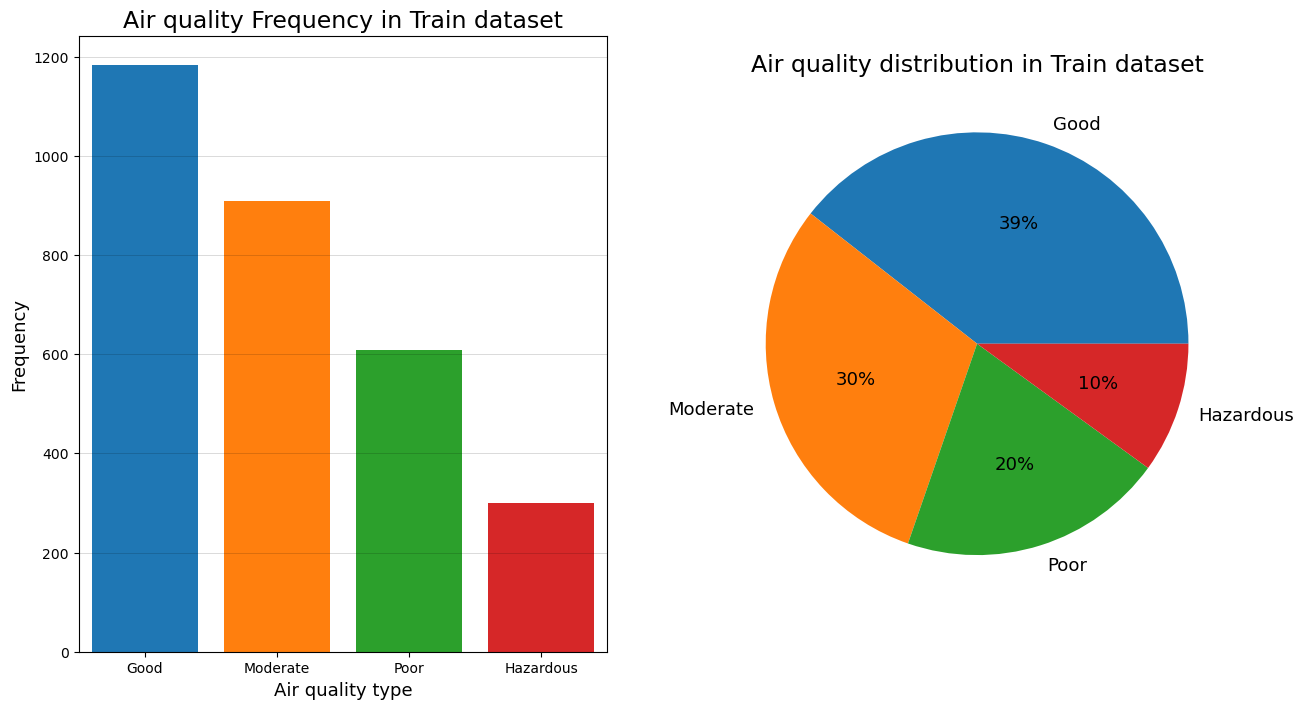

In [180]:
df_original = Xtrain

df_tmp = ytrain.copy()
df_tmp = df_tmp.astype("category")
df_tmp_counts = df_tmp.value_counts()


custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
sns.barplot(x = df_tmp_counts.index, y = df_tmp_counts.values, ax = ax1, order=df_tmp_counts.index)
for i, bar in enumerate(ax1.patches):
    bar.set_facecolor(custom_colors[i])

ax1.set_xlabel("Air quality type", fontsize = 13)
ax1.set_ylabel("Frequency",fontsize = 13)
ax1.set_title("Air quality Frequency in Train dataset",fontsize = 17)
ax1.grid(axis='y', color='black', alpha=.2, linewidth=.5)

animal_count = df_tmp.value_counts()
ax2 = fig.add_subplot(1,2,2)
ax2.pie(animal_count, labels=animal_count.index,autopct='%.0f%%', textprops={"fontsize": 13})
ax2.set_title("Air quality distribution in Train dataset", fontsize = 17)

In [181]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 4576 to 860
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    3000 non-null   float64
 1   Humidity                       3000 non-null   float64
 2   PM2.5                          3000 non-null   float64
 3   PM10                           3000 non-null   float64
 4   NO2                            3000 non-null   float64
 5   SO2                            3000 non-null   float64
 6   CO                             3000 non-null   float64
 7   Proximity_to_Industrial_Areas  3000 non-null   float64
 8   Population_Density             3000 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 234.4 KB


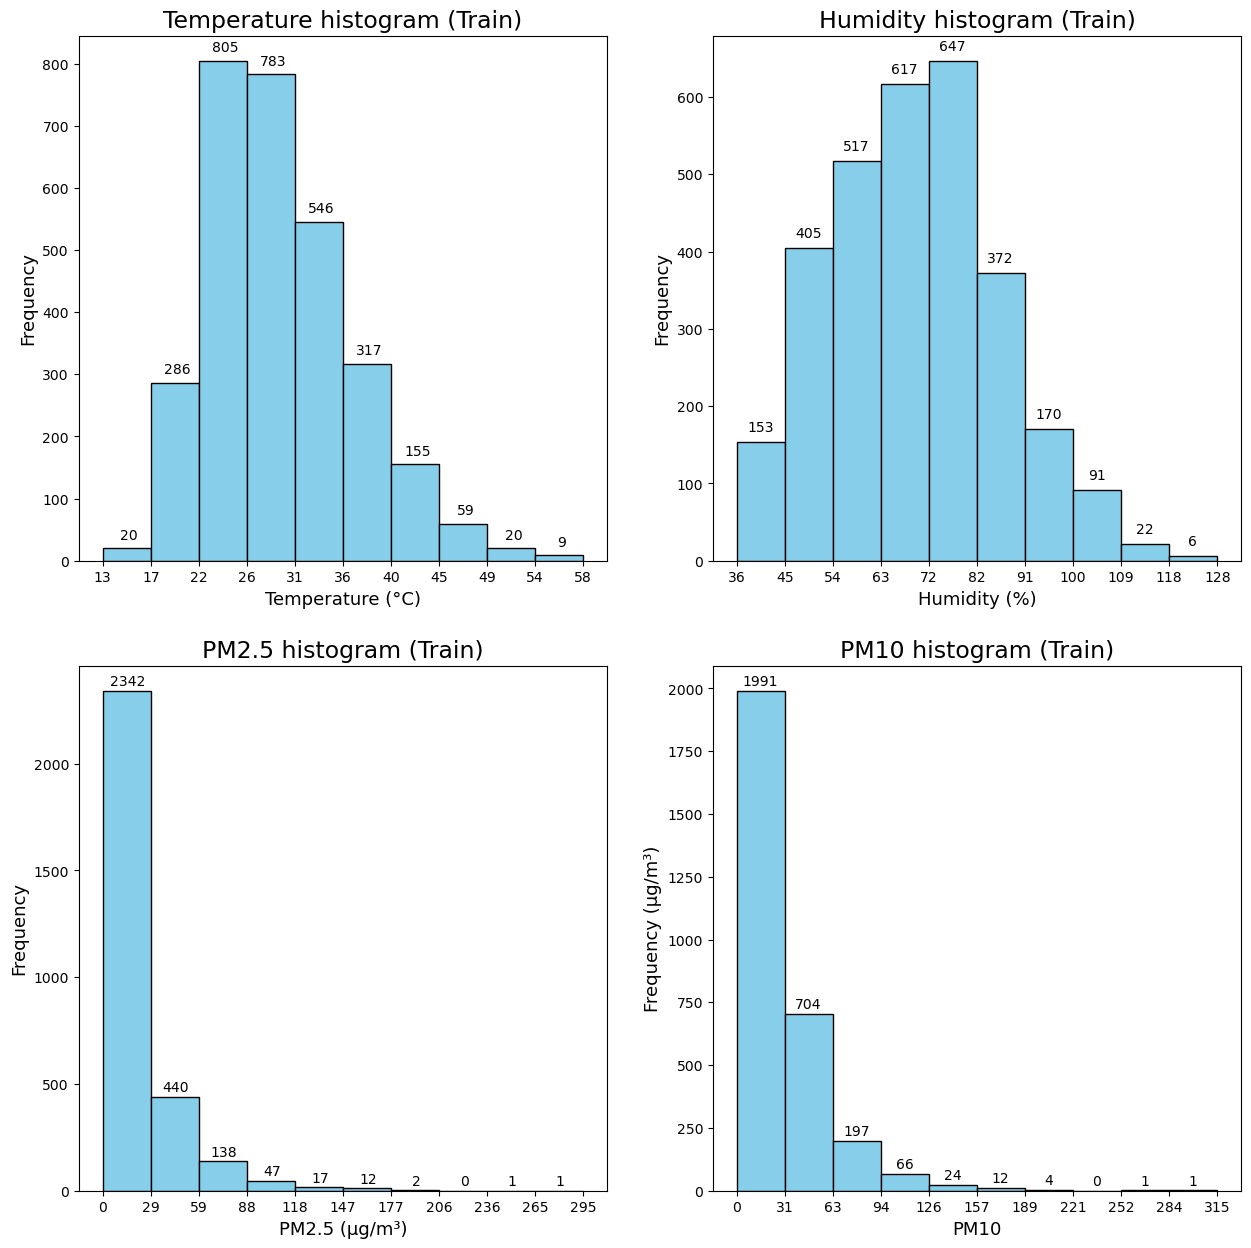

In [182]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

ax = axes[0,0]

# Plot the histogram
counts, bins, patches = ax.hist(df_original["Temperature"], edgecolor="black", color="skyblue")

ax.set_xticks(bins)  # Use bins directly for edge ticks
ax.set_xticklabels([int(x) for x in bins])

# Set titles and labels
ax.set_title("Temperature histogram (Train)", fontsize = 17)
ax.set_xlabel("Temperature (°C)", fontsize = 13)
ax.set_ylabel("Frequency", fontsize = 13)

for i, count in enumerate(counts):
    ax.text(bins[i]+2.5, count + 10, int(count), ha="center", va="bottom")

ax = axes[0,1]

# Plot the histogram
counts, bins, patches = ax.hist(df_original["Humidity"], edgecolor="black", color="skyblue")

ax.set_xticks(bins)  # Use bins directly for edge ticks
ax.set_xticklabels([int(x) for x in bins])

# Set titles and labels
ax.set_title("Humidity histogram (Train)", fontsize = 17)
ax.set_xlabel("Humidity (%)", fontsize = 13)
ax.set_ylabel("Frequency", fontsize = 13)

for i, count in enumerate(counts):
    ax.text(bins[i]+4.5, count + 10, int(count), ha="center", va="bottom")


ax = axes[1,0]

# Plot the histogram
counts, bins, patches = ax.hist(df_original["PM2.5"], edgecolor="black", color="skyblue")

ax.set_xticks(bins)  # Use bins directly for edge ticks
ax.set_xticklabels([int(x) for x in bins])

# Set titles and labels
ax.set_title("PM2.5 histogram (Train)", fontsize = 17)
ax.set_xlabel("PM2.5 (µg/m³)", fontsize = 13)
ax.set_ylabel("Frequency", fontsize = 13)

for i, count in enumerate(counts):
    ax.text(bins[i]+15.5, count + 10, int(count), ha="center", va="bottom")

ax = axes[1,1]

# Plot the histogram
counts, bins, patches = ax.hist(df_original["PM10"], edgecolor="black", color="skyblue")

ax.set_xticks(bins)  # Use bins directly for edge ticks
ax.set_xticklabels([int(x) for x in bins])

# Set titles and labels
ax.set_title("PM10 histogram (Train)", fontsize = 17)
ax.set_xlabel("PM10", fontsize = 13)
ax.set_ylabel("Frequency (µg/m³)", fontsize = 13)

for i, count in enumerate(counts):
    ax.text(bins[i]+15.5, count + 10, int(count), ha="center", va="bottom")

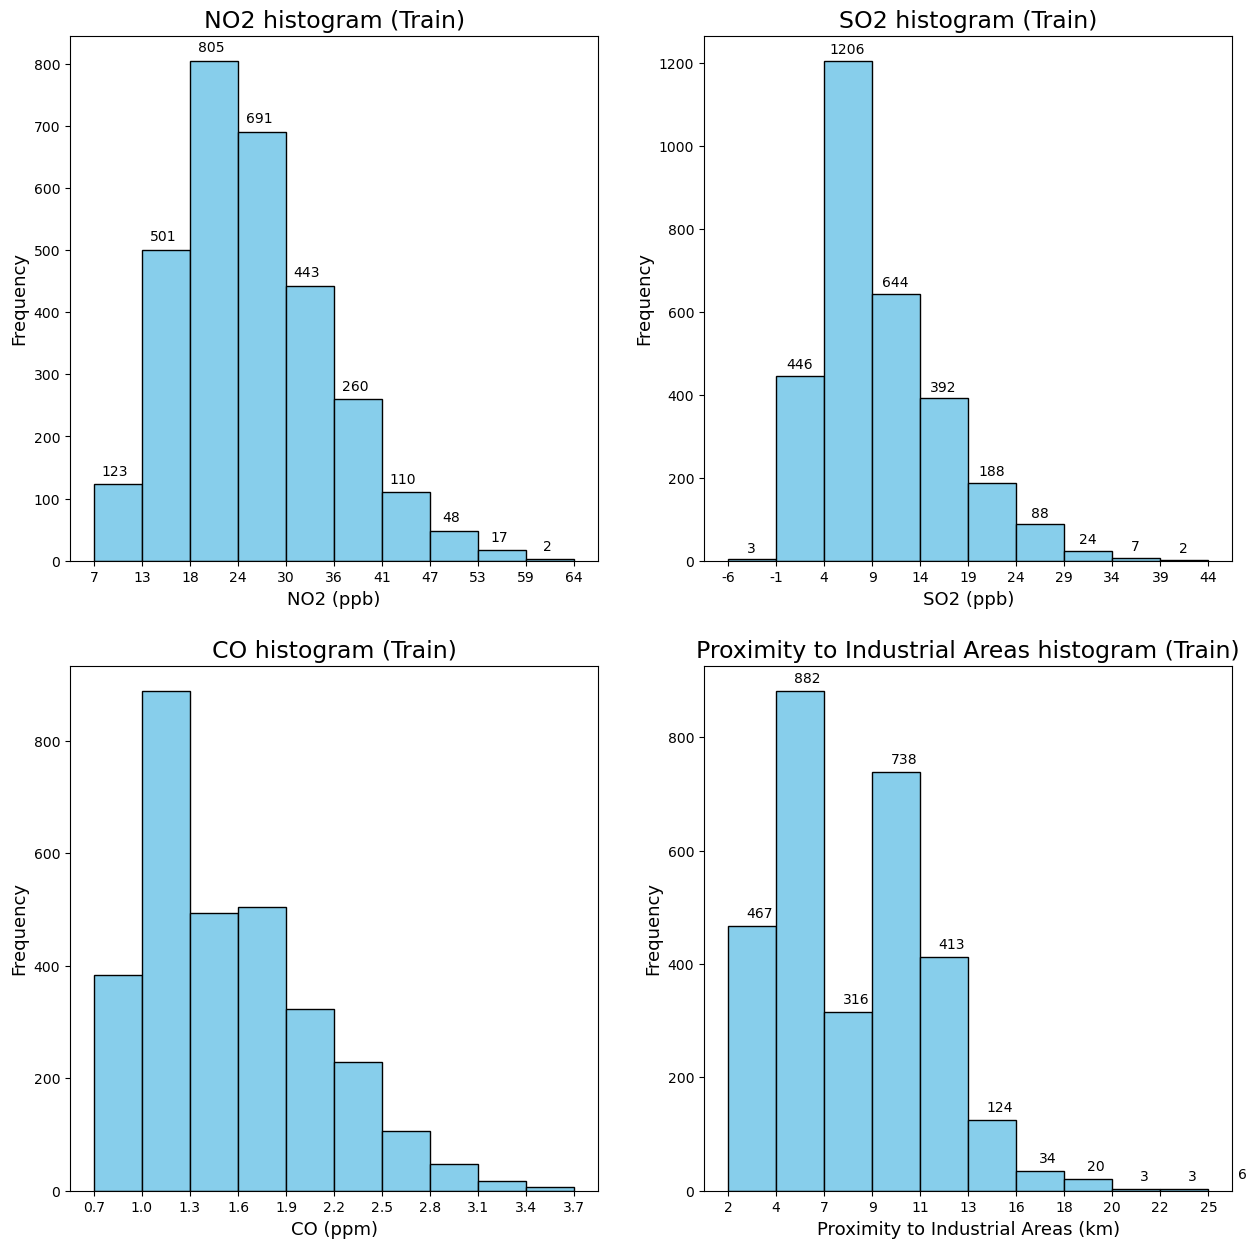

In [183]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

ax = axes[0,0]

# Plot the histogram
counts, bins, patches = ax.hist(df_original["NO2"], edgecolor="black", color="skyblue")

ax.set_xticks(bins)  # Use bins directly for edge ticks
ax.set_xticklabels([int(x) for x in bins])

# Set titles and labels
ax.set_title("NO2 histogram (Train)", fontsize = 17)
ax.set_xlabel("NO2 (ppb)", fontsize = 13)
ax.set_ylabel("Frequency", fontsize = 13)

for i, count in enumerate(counts):
    ax.text(bins[i]+2.5, count + 10, int(count), ha="center", va="bottom")

ax = axes[0,1]

# Plot the histogram
counts, bins, patches = ax.hist(df_original["SO2"], edgecolor="black", color="skyblue")

ax.set_xticks(bins)  # Use bins directly for edge ticks
ax.set_xticklabels([int(x) for x in bins])

# Set titles and labels
ax.set_title("SO2 histogram (Train)", fontsize = 17)
ax.set_xlabel("SO2 (ppb)", fontsize = 13)
ax.set_ylabel("Frequency", fontsize = 13)

for i, count in enumerate(counts):
    ax.text(bins[i]+2.5, count + 10, int(count), ha="center", va="bottom")


ax = axes[1,0]

# Plot the histogram
counts, bins, patches = ax.hist(df_original["CO"], edgecolor="black", color="skyblue")

ax.set_xticks(bins)  # Use bins directly for edge ticks
ax.set_xticklabels([f'{x:.1f}' for x in bins]) 

# Set titles and labels
ax.set_title("CO histogram (Train)", fontsize = 17)
ax.set_xlabel("CO (ppm)", fontsize = 13)
ax.set_ylabel("Frequency", fontsize = 13)

for i, count in enumerate(counts):
    ax.text(bins[i]+4.5, count + 10, int(count), ha="center", va="bottom")

ax = axes[1,1]

# Plot the histogram
counts, bins, patches = ax.hist(df_original["Proximity_to_Industrial_Areas"], edgecolor="black", color="skyblue")

ax.set_xticks(bins)  # Use bins directly for edge ticks
ax.set_xticklabels([int(x) for x in bins])

# Set titles and labels
ax.set_title("Proximity to Industrial Areas histogram (Train)", fontsize = 17)
ax.set_xlabel("Proximity to Industrial Areas (km)", fontsize = 13)
ax.set_ylabel("Frequency", fontsize = 13)

for i, count in enumerate(counts):
    ax.text(bins[i]+1.5, count + 10, int(count), ha="center", va="bottom")

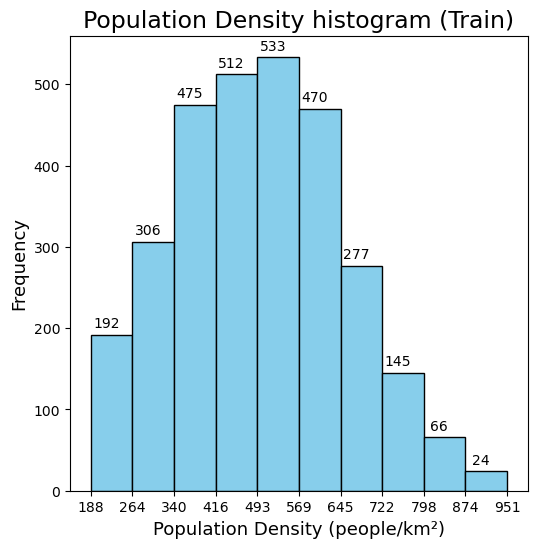

In [184]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13))

ax = axes[0,0]
# Plot the histogram
counts, bins, patches = ax.hist(df_original["Population_Density"], edgecolor="black", color="skyblue")

ax.set_xticks(bins)  # Use bins directly for edge ticks
ax.set_xticklabels([int(x) for x in bins])

# Set titles and labels
ax.set_title("Population Density histogram (Train)", fontsize = 17)
ax.set_xlabel("Population Density (people/km²)", fontsize = 13)
ax.set_ylabel("Frequency", fontsize = 13)

for i, count in enumerate(counts):
    ax.text(bins[i]+28.5, count + 5, int(count), ha="center", va="bottom")

axes[0,1].set_visible(False)
axes[1,1].set_visible(False)
axes[1,0].set_visible(False)

# Training model
We are trying to solve supervised learning problem, where based on *p* features $ X_{1}, ..., X_{p}$ (**Temperature**, **Humidity**, ...) we want to predict the value of target variable $Y$ (**Air Quality**). We can put all of these features into vector $\textbf{X} = (X_{1}, ... X{_p})^T$ which we will interpret as a random vector, and one of its specific realization will be denoted as $\mathbf{x}$. Let $\mathcal{X}$ where $\textbf{x} \in \mathcal{X}$ be set containing all possible values of these features, typically, and in our case, $\mathcal{X} = \mathbb{R}^p$. Then we can can describe our training dataset as N pairs $(\textbf{x}_{1}, Y_{1}), ..., (\textbf{x}_{p}, Y_{p})$ where $\textbf{x}_{i}$, respectively $Y_{i}$ is vector of features, respectively target variable. The basic concept of predicting value of data point $\mathbf{x} \in \mathcal{X}$ is finding the k-closest points from it (these points come from the train dataset). If we are solving regression problem, we then then the average from the target varibles of the k-closest neighbours, in classification problem (that's our case) we take the most frequent value from the target variables of the k-closest neighbours.\
\
When trying to find the best model, there are many things to consider. First of all we should define distance function.\
**Distance** also called **metric** defined on set $\mathcal{X}$ is function d: $\mathcal{X} \times \mathcal{X} \rightarrow [0, +\infty)$ such that for all $x, y, z \in \mathcal{X}$, the following conditions holds:\
$ i)\;d(x,y) \geq 0$, and $d(x,y) = 0$ if and only if $x = y$ (positive definiteness)\
$ ii)\;d(x,y) = d(y,x)$ (symetry)\
$ iii)\;d(x,y) \geq d(x,z) + d(z,y)$ (triangle inequality)

The most common distance function used is KNN is Minkowski distance also called q-norm defined as follows:\
$||x-y||_{q} = d_{q}(x,y) = \sqrt[q]{\sum_{i=1}^{p} (x_i - y_i)^q}$

After we have found k-nearest neighbours, we need to somehow decide what value we should predict. In our case, we could just precict the value with the most frequent target variable. What we can also do is try weighted voting, that means that closer neighbours will have vote with higher value.\
Common choice for weight is inverse distance weighting\
$w_{i} = \frac{1}{d(x,y)}$\
For each category $c$ of the target variable we count the total weighted vote $W_{c} = \sum_{Y_i \in \mathcal{N}} w_i \cdot 1(Y_i = c)$\
where $\mathcal{N}$ is set of target variables of k-nearest neighbours, we then choose $\hat{y} = \arg\max W_c $ where $c$ is every possible category of target variable as our prediction

In [186]:
def train_model(*args,**kwargs):
    """Function, that trains model with specific paraketrs, defined in kwargs.
    ---
    Attributes:
    *args: Xtrain,Ytrain
    **kwargs: options for training model
    ---
    Return: trained model
    """
    X = args[0]
    y = args[1]
    return KNeighborsClassifier(**kwargs).fit(X,y)

In [187]:
color_map = {
    'Good': 'green',
    'Moderate': 'yellow',
    'Poor': 'orange',
    'Hazardous': 'red'
}
category_order = ["Good", "Moderate", "Poor", "Hazardous"]

# Interactive graph
- Here we have interactive graph that shows how our model predicts on validating datasets based on different hyperparameters.

In [311]:
def show_graph(X, y_pred, x_ax='Temperature', y_ax='Humidity'):
    df_viz = X.copy()
    df_viz['Air Quality'] = y_pred
    fig = px.scatter(df_viz, x=x_ax, y=y_ax, color='Air Quality', color_discrete_map=color_map,
                     hover_data=df_viz, title='KNN Visualization',
                     category_orders={'Air Quality':category_order})

    fig.update_layout(
        title_font=dict(size=17), 
        xaxis_title_font=dict(size=13), 
        yaxis_title_font=dict(size=13)  
    )
    
    fig.show()

In [313]:
n_neighbors_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description="n_neighbors")
p_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description="p_metric")
scale = widgets.RadioButtons(
    options=['None', 'Standard', 'MinMax'],
    description='Choose normalization:',
    disabled=False
)
weights = widgets.RadioButtons(
    options=['uniform', 'distance'],
    description='Chose weight:'
)

In [315]:
#| label: dynamic_graph
#| fig-cap: "Interactive KNN visualization"
#| tags: [interactive]
#| echo: false
#| output: widget
def dynamic_graph(**kwargs):
    scale = kwargs.pop('scaler')
    Xtrain_fit = Xtrain.copy()
    Xval_fit = Xval.copy()
    if scale == 'Standard':
        scaler = StandardScaler()
        Xtrain_fit = scaler.fit_transform(Xtrain)
        Xval_fit = scaler.transform(Xval)

    elif scale == 'MinMax':
        scaler = MinMaxScaler()
        Xtrain_fit = scaler.fit_transform(Xtrain)
        Xval_fit = scaler.transform(Xval)
        
    clf = train_model(Xtrain_fit,ytrain,**kwargs)
    display(f'Accuracy (val): {clf.score(Xval_fit,yval)}')
    show_graph(Xval,clf.predict(Xval_fit))


interactive_plot = interactive(dynamic_graph, n_neighbors=n_neighbors_slider, p=p_slider,scaler=scale,
                               weights=weights)
display(interactive_plot)

interactive(children=(IntSlider(value=5, description='n_neighbors', max=20, min=1), IntSlider(value=5, descrip…

# Finding the Best model (Hyperparameter tuning)
When finding the best model, there are many things to consider. Our goal is to somehow maximize the classification accuracy on new data, that the model has never seen before. Accuracy is defined as\
$\frac{ \text{number of correctly classified}}{ \text{number of all classified}}$
The accuracy which we are trying to maximize is the accurate of how our model built using **train** dataset will predict on **validating** dataset. In order to maximize this accuracy, we can try changing the number of neighbours (k), then we can try changing the distance metric, lastly, we can try whether using weighted distance makes any difference. We build our model on combination of these different possibilites and for every one of them we predict the accuracy on **validating** dataset. We then chose the model with the highest accuracy.

In [317]:
def find_best(*args):
    """ Function finding best parametrs for specified data
    ---
    Attributes:
    Xtrain, ytrain, Xval, Yval
    """
    param_grid = {
        'n_neighbors': range(1,15), 
        'p': range(1,4),
        'weights': ['uniform', 'distance']
    }
    param_comb = ParameterGrid(param_grid)
    val_acc = []
    train_acc = []
    for params in param_comb:
        clfKNN = KNeighborsClassifier(**params)
        clfKNN.fit(args[0], args[1])
        train_acc.append(clfKNN.score(args[0],args[1]))
        val_acc.append(clfKNN.score(args[2],args[3]))
    return param_comb[np.argmax(val_acc)], train_acc, val_acc

In [320]:
best_params_no_scale, train_acc, val_acc = find_best(Xtrain,ytrain,Xval,yval)

scaler = StandardScaler()
Xtrain_fit = scaler.fit_transform(Xtrain)
Xval_fit = scaler.transform(Xval)
best_params_standard, train_acc_standard, val_acc_standard = find_best(Xtrain_fit,ytrain,Xval_fit,yval)

scaler = MinMaxScaler()
Xtrain_fit = scaler.fit_transform(Xtrain)
Xval_fit = scaler.transform(Xval)
best_params_minmax, train_acc_minmax, val_acc_minmax = find_best(Xtrain_fit,ytrain,Xval_fit,yval)

## No normalization accuracy

Using Min-Max normalization, the best accuracy we get is 08331

In [196]:
clfKNN = KNeighborsClassifier(**best_params_no_scale)
clfKNN.fit(Xtrain, ytrain)
y_knn_val = clfKNN.predict(Xval)
display(metrics.accuracy_score(yval, y_knn_val))

0.833

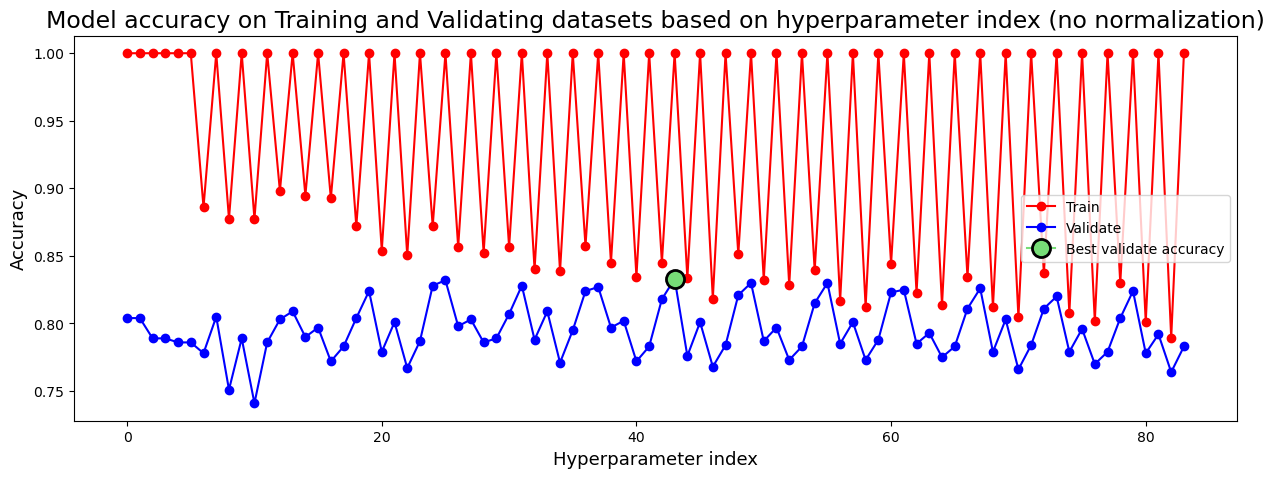

In [197]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Model accuracy on Training and Validating datasets based on hyperparameter index (no normalization)", fontsize=17)
ax.plot(train_acc,'or-')
ax.plot(val_acc,'ob-')


max_idx = np.argmax(val_acc)
ax.plot(max_idx, val_acc[max_idx], marker='o', color='#77DD77', markersize=13, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('Hyperparameter index', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.legend(['Train', 'Validate', 'Best validate accuracy'])

# Normalization
One technique that can also help with making the model more accurate is normalization. In some cases, the features are difficult to compare and it is essentially impossible to find a universal measure. This can be addressed by using clever methods to normalize the data using linear transformation. The simplest method used to normalize data is called **Min-Max** normalization which scales every element in selected feature into interval $[0,1]$. It is defined as follows:\
For given feature let's call his minimal value $\text{min}_x$ and the maximal value $\text{max}_x$, then we will define the value $x_i$ of this feature\
$x_i \leftarrow \frac{ x_i - \text{min}_x}{ \text{max}_i - \text{min}_x}$

Another commonly used normalization method is standardization, defined as follows
$x_i \leftarrow \frac{x_i - \bar{x}}{\sqrt{s_x^2}}$ where $\bar{x} = \frac{1}{n} \sum_{i} x_i$ is sample mean and $s_x^2 = \frac{1}{n-1} \sum_{i}^{} {(x_i - \bar{x})^2}$

## Standardization accuracy
Using Min-Max normalization, the best accuracy we get is 092311

In [200]:
scaler = StandardScaler()
Xtrain_fit = scaler.fit_transform(Xtrain)
Xval_fit = scaler.transform(Xval)

clfKNN = KNeighborsClassifier(**best_params_standard)
clfKNN.fit(Xtrain_fit, ytrain)
y_knn_val = clfKNN.predict(Xval_fit)
display(metrics.accuracy_score(yval, y_knn_val))

0.931

0.931

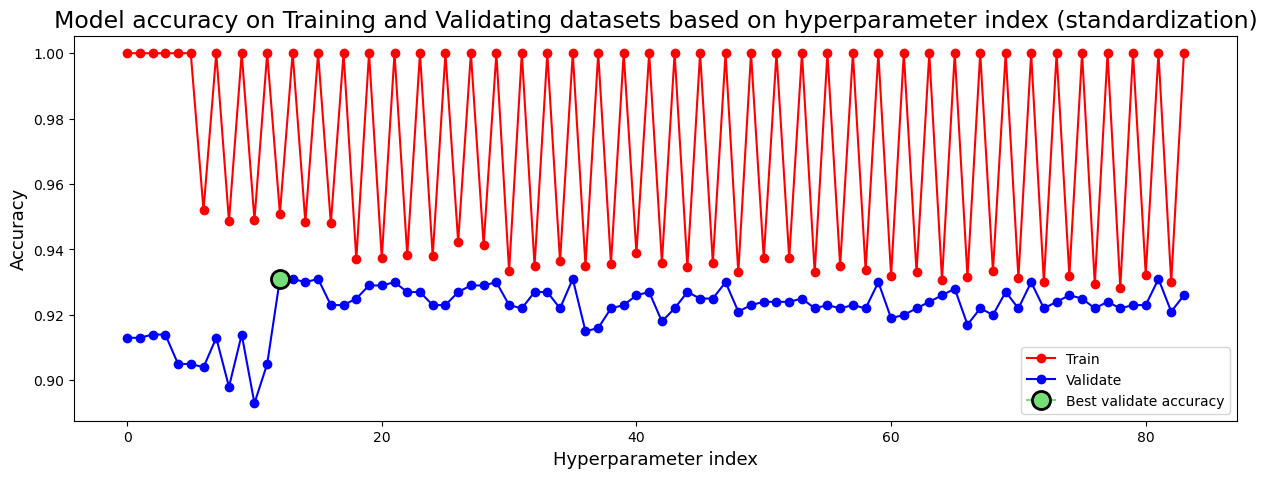

In [201]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Model accuracy on Training and Validating datasets based on hyperparameter index (standardization)", fontsize=17)
ax.plot(train_acc_standard,'or-')
ax.plot(val_acc_standard,'ob-')


max_idx = np.argmax(val_acc_standard)
#display(val_acc_standard[max_idx])
ax.plot(max_idx, val_acc_standard[max_idx], marker='o', color='#77DD77', markersize=13, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('Hyperparameter index', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.legend(['Train', 'Validate', 'Best validate accuracy'])

## Min-Max accuracy
Using Min-Max normalization, the best accuracy we get is 0.931

In [238]:
scaler = MinMaxScaler()
Xtrain_fit = scaler.fit_transform(Xtrain)
Xval_fit = scaler.transform(Xval)

clfKNN = KNeighborsClassifier(**best_params_minmax)
clfKNN.fit(Xtrain_fit, ytrain)
y_knn_val = clfKNN.predict(Xval_fit)
display(metrics.accuracy_score(yval, y_knn_val))

0.942

0.942

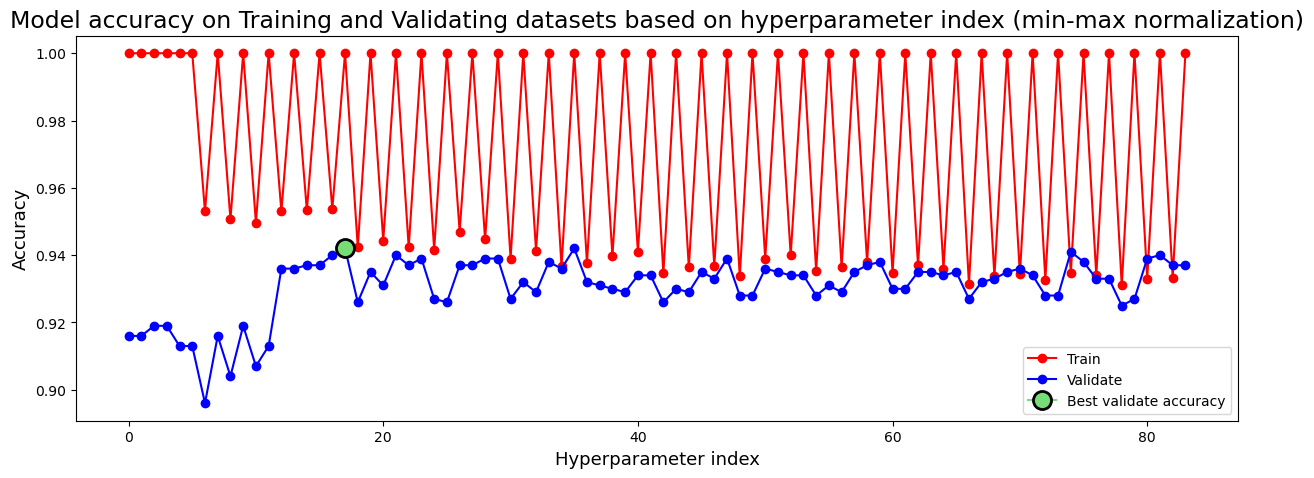

In [240]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Model accuracy on Training and Validating datasets based on hyperparameter index (min-max normalization)", fontsize=17)
ax.plot(train_acc_minmax,'or-')
ax.plot(val_acc_minmax,'ob-')


max_idx = np.argmax(val_acc_minmax)
#display(val_acc_minmax[max_idx])
ax.plot(max_idx, val_acc_minmax[max_idx], marker='o', color='#77DD77', markersize=13, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('Hyperparameter index', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.legend(['Train', 'Validate', 'Best validate accuracy'])

# Choosing the final model
Based on the results, we can see that the best model is the model that uses Min-Max normalization, uses weighted distance, 3-norm and 3 neighbours with accuracy of 0.942. We can also graph confusion matrix, that shows how accurately we predicted each type of category. Finally, we will predict the expected accuracy on the **test** dataset, which will give us an estimate of how accurately the model will perform on new, unseen data.

In [274]:
best_params_minmax

{'weights': 'distance', 'p': 3, 'n_neighbors': 3}

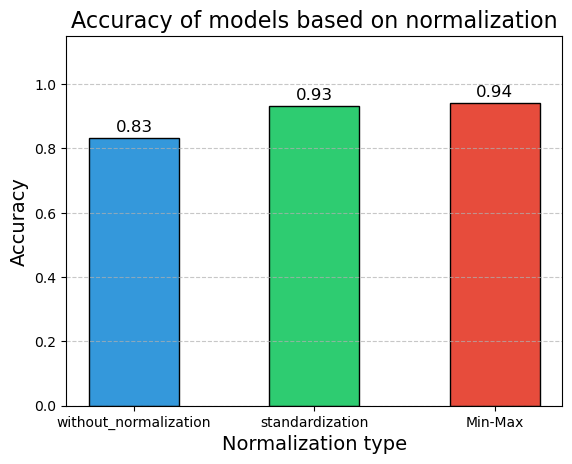

In [276]:
max_idx = np.argmax(val_acc)
max_idx_standard = np.argmax(val_acc_standard)
max_idx_minmax = np.argmax(val_acc_minmax)

labels = ['without_normalization', 'standardization', 'Min-Max']
values = [val_acc[max_idx], val_acc_standard[max_idx_standard], val_acc_minmax[max_idx_minmax]] 

fig, ax = plt.subplots()

colors = ['#3498db', '#2ecc71', '#e74c3c']

ax.bar(labels, values, color=colors, edgecolor='black', width=0.5)

ax.set_ylim(0, 1.15)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.set_xlabel("Normalization type", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_title("Accuracy of models based on normalization", fontsize=16)

ax.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(values):
    ax.text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=12)

plt.show()


Text(0, 0.5, 'True')

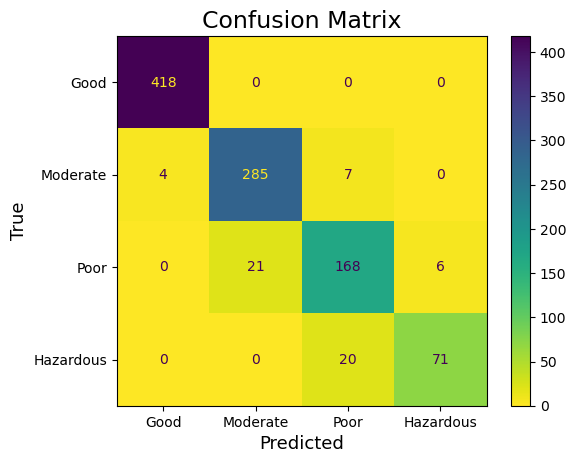

In [278]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusionMatrixDT = metrics.confusion_matrix(yval, y_knn_val)
fig, ax = plt.subplots()
custom_order = ['Good', 'Moderate', 'Poor', 'Hazardous']

confusionMatrixDT = confusion_matrix(yval, y_knn_val, labels=custom_order)

disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrixDT,
                              display_labels=custom_order)
disp.plot(ax=ax, cmap="viridis_r")
ax.set_title("Confusion Matrix", fontsize = 17)
ax.set_xlabel("Predicted", fontsize = 13)
ax.set_ylabel("True", fontsize = 13)

## Test accuracy
Our model has 0.921 accuracy on test dateset, this is the accuracy that we can expect on new data

In [283]:
scaler = MinMaxScaler()
Xtrain_fit = scaler.fit_transform(Xtrain)
Xtest_fit = scaler.transform(Xtest)

clfKNN = KNeighborsClassifier(**best_params_minmax)
clfKNN.fit(Xtrain_fit, ytrain)
y_knn_val = clfKNN.predict(Xtest_fit)
display(metrics.accuracy_score(ytest, y_knn_val))

0.921

#### Sources:

<https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm> \
<https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment/data>
